<img src="./logo_UNSAM.jpg" align= "right" width= "150" /> -->
## APS
## Trabajo práctico semanal 5: *Estimación espectral: Ancho de banda de señales reales*
### Violeta Manterola

En el repositorio PDStestbench encontrará tres tipos de señales registradas:

Electrocardiograma (ECG). En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.
Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.


---------------------------------------------------------------------------------------------------------------------------------------------------------

El objetivo de este trabajo fue realizar la *estimación de la densidad de pontencia* (**PSD**) de disntintos tipos de señales, la primera corresponde a una pletismografía (**PPG**); la segunda a un electrocardgiograma (**ECG**), en el cual cabe destacar que se analizaron las primeras 12000 muestras; y las últimas tres corresponden a distintas señales de **audio**. 

**Elección método estimación :**
Para estmiar la PSD se utilizó el método de **Blackman-Tukey** el cual mejora el calculo del periodograma al estimar mejor la funcion de autocrorrelación, es decir, aplica la transformada de Fourier a la función de autocorrelación y una ventana de tamaño M. A diferencia del método de welch que se basa en el promedio del periodograma de cada segmento; en cambio, con blackman-tukey al usar toda la señal de forma global y calcular una autocorrelación promedio, hace que resulte más estable estadísticamente. También en cuanto a la implementación la función de blackman-tukey perimte estudiar, con mayor facilidad o intución, la influencia del parámetro M (tamaño de ventana)
    
A partir de la PSd estimada se calculó el ancho de banda de cada señal considerando el rango de frecuencias que contiene entre el 95% y el 98% de la energía total, como criterio de concentración energética; teniendo en cuenta que son señales reales por lo tanto no tienen un ancho de banda perfectamente definido. Es por esto que no se usa el 100% de la energía por ejemplo, asi se evita sobreestimar el ancho de banda por picos débiles y aleatorios.

Por último se comparan los anchos de banda obtenidos con las distintas señales; se espera que las dos primeras al ser señales fisiológicas (una más compleja que la otra) difieran en el rango de frecuencias pero que ambos sean significativente de menor frecuencia que aquellos que corresponden a las señales de audio. En estas últimas, deberían difererir en donde se concentra la energía según el tono y la complejidad armónica de cada archivo. 

In [30]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io as sio
from scipy.io.wavfile import write
import pandas as pd

#función para estimar densidad espectral de potencia usando método de Blackman-Tukey
def blackman_tukey(x,  M = None,  window_type='blackman'):    
    
    # N = len(x)
    x_z = x.shape
    
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1
    # hay que aplanar los arrays por np.correlate.
    # usaremos el modo same que simplifica el tratamiento
    # de la autocorr
    xx = x.ravel()[:r_len];

    r = np.correlate(xx, xx, mode='same') / r_len
    
    if window_type == 'blackman':
        ventana = sig.windows.blackman(r_len)
    elif window_type == 'hamming':
        ventana = sig.windows.hamming(r_len)

    Px = np.abs(np.fft.fft((r * ventana), n = N))

    Px = Px.reshape(x_z)

    return Px;

#función para estimar el ancho de banda (BW)
def estimar_BW(Pxx, f):
    N1=len(Pxx)
    Pxx_half = Pxx[:N1//2] #tomo solo la parte positiva
    f_half = f[:N1//2]
    energia_total = np.sum(Pxx_half)
    energia_acum = np.cumsum(Pxx_half)
    energia_norm = energia_acum / energia_total

    #ubica el indice donde se concentra el 95% y el 98% de la energía total => dentro de ese rango se encuentra la frecuencia de ancho de banda segun este criterio
    idx_95 = np.where(energia_norm >= 0.95)[0][0]
    idx_98 = np.where(energia_norm >= 0.98)[0][0]

    f_95 = f_half[idx_95]
    f_98 = f_half[idx_98]
    bw = f_98 - f_95 #esto seria el ancho de banda efectivo --> 
    return f_95, f_98, bw, energia_norm, f_half,Pxx_half

#funcion general que procesa las señales
def analizar_signal(nombre_archivo, fs=None, nombre='Señal'):
    
    # Cargar y normalizar (tengo q separar con if, xq el archivo de audio esta en .wav y se lee de otra manera)
    if nombre_archivo.endswith('.npy'):
        x = np.load(nombre_archivo).ravel()  
    elif nombre_archivo.endswith('.wav'):
        fs, x = sio.wavfile.read(nombre_archivo)
    else:
        raise ValueError("Formato de archivo no compatible (.npy o .wav)")
    
    x = x - np.mean(x)
    #normalizo x varianza. 
    x = x / np.std(x)
    N = len(x)
    # print(f"Muestras: {N}, Fs: {fs} Hz")

    # PSD Blackman-Tukey 
    psd_bt = blackman_tukey(x) #en caso de no espacificar toma x default M=N//5
    frecs = np.fft.fftfreq(N, d=1/fs)

    # Ancho de banda
    f95, f98, bw, energia_norm, f_half,Pxx_half = estimar_BW(psd_bt, frecs)

    # Plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(frecs[:N//2], 10 * np.log10(psd_bt[:N//2] + 1e-12))
    plt.title(f'PSD (Blackman-Tukey) - {nombre}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [dB]')
    plt.grid(True)

    #plot para que se aprecie mejor el rango del ancho de banda, es decir, con "zoom". 
    # Zoom automático al rango de interés + margen (el q se quiera, en este caso cosnidere 10 apropiado)
    x_min = max(0, f95 - 10 * (f98 - f95))
    x_max = f98 + 10 * (f98 - f95)
    plt.subplot(1, 2, 2)
    plt.plot(f_half, 10 * np.log10(Pxx_half + 1e-12), label='PSD (dB)', color='navy')
    plt.axvline(f95, color='red', linestyle='--', label=f'f95 = {f95:.2f} Hz')
    plt.axvline(f98, color='green', linestyle='--', label=f'f98 = {f98:.2f} Hz')    
    plt.xlim(x_min, x_max)
    plt.title(f'PSD (Blackman-Tukey) - Zoom en BW - {nombre}')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('PSD [dB]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #plot de la variable energía acumulada, q marca el BW.
    plt.figure(figsize=(6, 4))
    plt.plot(f_half, energia_norm)
    plt.axhline(0.95, color='r', linestyle='--')
    plt.axhline(0.98, color='g', linestyle='--')
    plt.axvline(f95, color='r', linestyle=':', label=f'f95 = {f95:.2f} Hz')
    plt.axvline(f98, color='g', linestyle=':', label=f'f98 = {f98:.2f} Hz')
    plt.title('Energía acumulada (normalizada)')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Energía acumulada')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    resultados = {
        'Señal': nombre,
        'Fs [Hz]': fs,
        #'Rango de freceuncias BW [Hz]' : (round(f95, 2), round(f98, 2)),
        'BW 95% [Hz]': round(f95, 2),
        'BW 98% [Hz]': round(f98, 2),
        #'f_95 [Hz]': round(f95, 2),
        #'f_98 [Hz]': round(f98, 2),
        #'BW 95-98 [Hz]': round(bw, 2)
    }
    return resultados


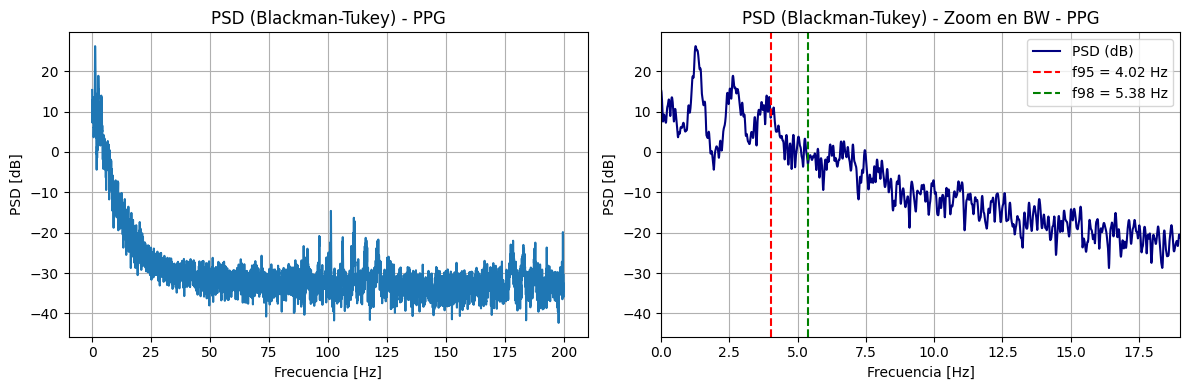

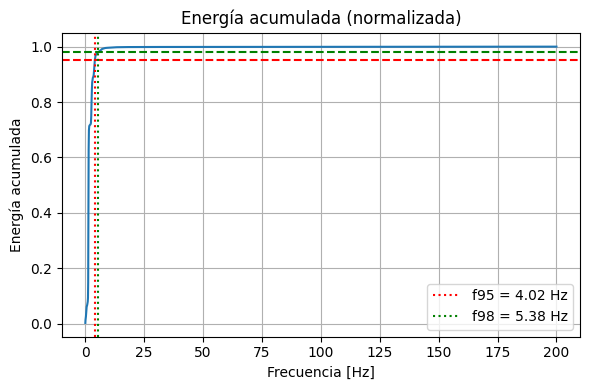

,Señal,Fs [Hz],BW 95% [Hz],BW 98% [Hz]
0,PPG,400,4.02,5.38


In [2]:
#Señal de PPG
resultados_PPG= analizar_signal('ppg_sin_ruido.npy', fs=400, nombre='PPG')

# Para mostrar como tabla:
tabla_1 = pd.DataFrame([resultados_PPG])
display(tabla_1.round(2))

Esta señal, PPG, corresponde a una señal de carácter biológico la cual se utiliza para medir cambios en el flujo sanguíneo y así monitoreaar por ejemplo la frecuencia cardíaca, entre otros aspectos fisológicos. Es por esto que el rango del ancho de banda se presenta a bajas frecuencias, ya que corresponde a un comportamiento de naturaleza lenta, como lo es el cambio del fluido sanguíneo, por ende el  95-98% de la energía se concentra alrededor de los 5Hz. 

------------------------------------------------------------------------------------------------------------------
### -Comparación dos tipos de ventana para la estimación con BT: 

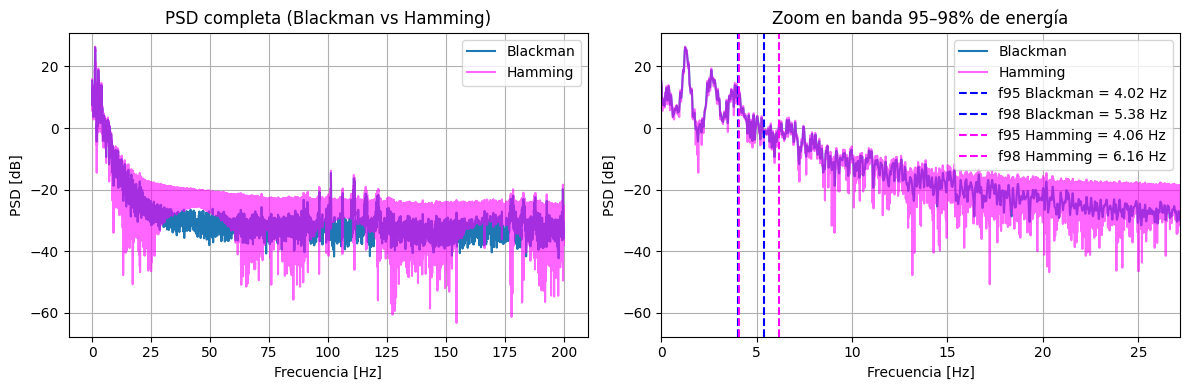

Blackman: f95 = 4.02 Hz, f98 = 5.38 Hz, BW = 1.36 Hz
Hamming : f95 = 4.06 Hz, f98 = 6.16 Hz, BW = 2.10 Hz


In [55]:
# Comparación entre ventanas para ver efecto en la PSD
x = np.load('ppg_sin_ruido.npy').reshape(-1)
fs = 400
x = x - np.mean(x)
x = x / np.std(x)
N = len(x)

# Calcular PSDs con distintas ventanas
psd_blackman = blackman_tukey(x, window_type='blackman')
psd_hamming = blackman_tukey(x, window_type='hamming')
frecs = np.fft.fftfreq(N, 1/fs)

# Estimar BW para ambas
f95_b, f98_b, bw_b, _, _, _ = estimar_BW(psd_blackman, frecs)
f95_h, f98_h, bw_h, _, _, _ = estimar_BW(psd_hamming, frecs)

# Frecuencia positiva
f_half = frecs[:N//2]
psd_b_half = psd_blackman[:N//2]
psd_h_half = psd_hamming[:N//2]

# Margen para zoom
x_min = max(0, min(f95_b, f95_h) - 10 * max(bw_b, bw_h))
x_max = max(f98_b, f98_h) + 10 * max(bw_b, bw_h)

# Plots
plt.figure(figsize=(12, 4))

# Subplot 1: PSD completa
plt.subplot(1, 2, 1)
plt.plot(f_half, 10 * np.log10(psd_b_half + 1e-12), label='Blackman')
plt.plot(f_half, 10 * np.log10(psd_h_half + 1e-12), label='Hamming', color='magenta', alpha=0.6)
plt.title(f'PSD completa (Blackman vs Hamming)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)
plt.legend()

# Subplot 2: Zoom en ancho de banda
plt.subplot(1, 2, 2)
plt.plot(f_half, 10 * np.log10(psd_b_half + 1e-12), label='Blackman')
plt.plot(f_half, 10 * np.log10(psd_h_half + 1e-12), label='Hamming', color='magenta', alpha=0.6)
# Líneas verticales f95 y f98
plt.axvline(f95_b, color='blue', linestyle='--', label=f'f95 Blackman = {f95_b:.2f} Hz')
plt.axvline(f98_b, color='blue', linestyle='--', label=f'f98 Blackman = {f98_b:.2f} Hz')
plt.axvline(f95_h, color='magenta', linestyle='--', label=f'f95 Hamming = {f95_h:.2f} Hz')
plt.axvline(f98_h, color='magenta', linestyle='--', label=f'f98 Hamming = {f98_h:.2f} Hz')
plt.xlim(x_min, x_max)
plt.title('Zoom en banda 95–98% de energía')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('PSD [dB]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar comparación
print(f"Blackman: f95 = {f95_b:.2f} Hz, f98 = {f98_b:.2f} Hz, BW = {bw_b:.2f} Hz")
print(f"Hamming : f95 = {f95_h:.2f} Hz, f98 = {f98_h:.2f} Hz, BW = {bw_h:.2f} Hz")

Gracias a esta comparación podemos ver como la ventana Hamming presenta una mayor cantidad de fuga espectral (spectral leakage), auqnue no tanto en el aréa de interés, igual resulta más conveniente utilizar la ventana Blackman ya que en gráfico se observa que la PSD con ventana Blackman tiene menos fluctuaciones y se atenúa más fuertemente en frecuencias alejadas del contenido principal.

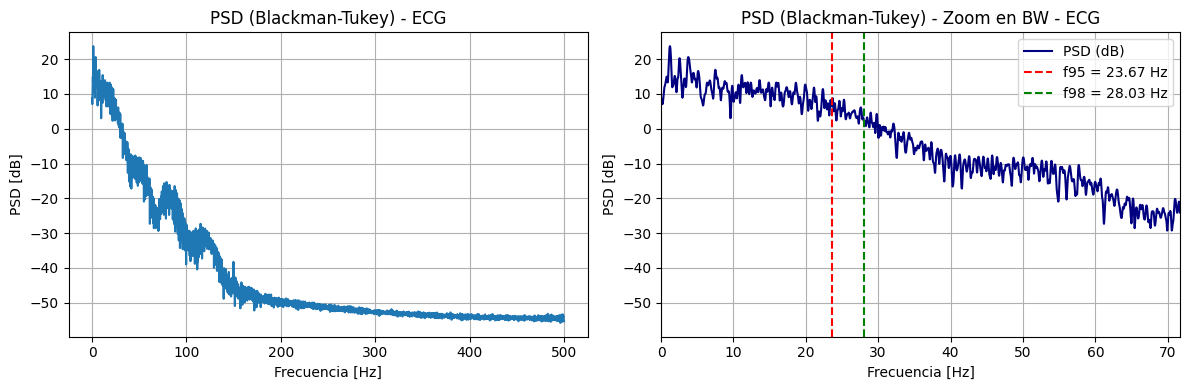

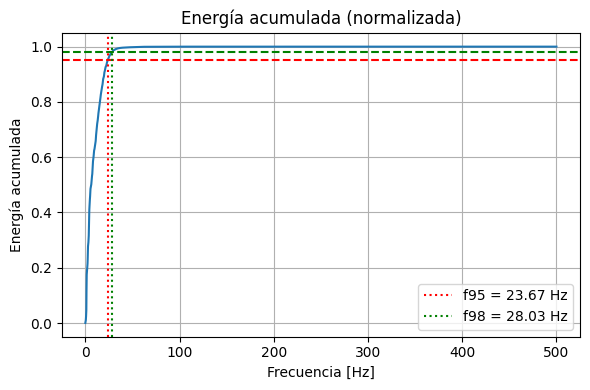

,Señal,Fs [Hz],BW 95% [Hz],BW 98% [Hz]
0,ECG,1000,23.67,28.03


In [4]:
#Señal de ECG
resultados_ECG= analizar_signal('ecg_sin_ruido.npy', fs=1000, nombre='ECG')

# Para mostrar como tabla:
tabla_2 = pd.DataFrame([resultados_ECG])
display(tabla_2.round(2))

El ECG es otro tipo de señeal fisiológica que registra las señales eléctricas del corazón. Esta presenta un ancho de banda de frecuencia más alta y con mayor variación entre los puntos que acumulan el 95% y 98% de la energía total, en comparación con la analizada previamente. Dicho comportamiento se adjudica a que la señal del ecg es más compleja ya que esta compuesta por picos de mayor frecuencia, como el complejo QRS (asociado a ala despolarización de los ventrículos) donde la onda R es la componenete de mayor frecuencia, y esto provoca una mayor variación entre los criterios de tomar el 95% y 98% de la energía acumulada.

------------------------------------------------------------------------------------------------------------------
### -Comparación distintos tamaño de ventana para la estimación con BT: 

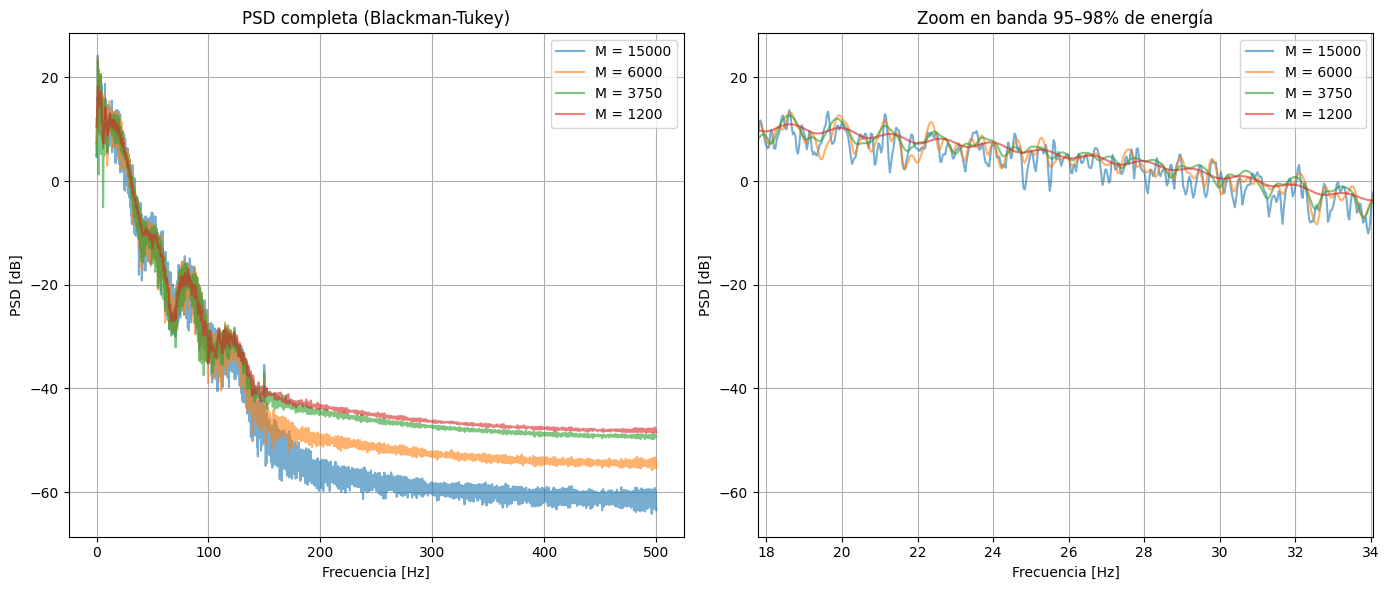

,M,f95 [Hz],f98 [Hz],BW (98-95%) [Hz]
0,15000,22.77,27.40,4.63
1,6000,23.67,28.03,4.37
2,3750,24.73,29.07,4.33
3,1200,24.43,28.87,4.43


In [52]:
fs = 1000
x = np.load('ecg_sin_ruido.npy').reshape(-1)
x = x - np.mean(x)
x = x / np.std(x)
N = len(x)
M_vals = [N//2, N//5, N//8, N//25]

plt.figure(figsize=(14, 6))

# Crear subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Guardar resultados
resultados = []

for M in M_vals:
    psd = blackman_tukey(x, M=M)
    frecs = np.fft.fftfreq(N, 1/fs)
    
    # Parte positiva del espectro
    f_half = frecs[:N//2]
    psd_half = psd[:N//2]
    
    # BW
    f95, f98, bw, _, _, _ = estimar_BW(psd, frecs)
    resultados.append((M, f95, f98, bw))

    # --- Subplot 1: PSD completa ---
    ax1.plot(f_half, 10 * np.log10(psd_half + 1e-12), label=f'M = {M}', alpha=0.6)

    # --- Subplot 2: Zoom en BW ---
    ax2.plot(f_half, 10 * np.log10(psd_half + 1e-12), label=f'M = {M}', alpha=0.6)
    # ax2.axvline(f95, color='red', linestyle='--', alpha=0.3)
    # ax2.axvline(f98, color='green', linestyle='--', alpha=0.3)

# Personalización
ax1.set_title('PSD completa (Blackman-Tukey)')
ax1.set_xlabel('Frecuencia [Hz]')
ax1.set_ylabel('PSD [dB]')
ax1.grid(True)
ax1.legend()

ax2.set_title('Zoom en banda 95–98% de energía')
ax2.set_xlabel('Frecuencia [Hz]')
ax2.set_ylabel('PSD [dB]')
ax2.grid(True)
ax2.legend()

# Limitar eje X en zoom: centrado alrededor de f95-f98
margen = 5  # Hz
f_min = min([r[1] for r in resultados]) - margen
f_max = max([r[2] for r in resultados]) + margen
ax2.set_xlim(f_min, f_max)

plt.tight_layout()
plt.show()

# Mostrar tabla
tabla = pd.DataFrame(resultados, columns=['M', 'f95 [Hz]', 'f98 [Hz]', 'BW (98-95%) [Hz]'])
display(tabla.round(2))



Lo clave a destacar, en base a esta comparación del TAMAÑO de la ventana que utiliza BT, es el compromiso entre resolución espectral y varianza del estimador. El tamaño que yo le de a M determina el tiempo de correlación máximo considerado en la estimación. Es por esto que como veo en los gráficos un valor más pequeño de M reduce la varianza de la estimación espectral, pero empeora la resolución en frecuencia, como se observa en el aplanamiento de los picos espectrales (son más suaves) se puede ver claramente en la señal roja que tiene un tamaño de ventana de 1200 . Entonces mientras mayor sea el tamaño de la ventana, más información tengo para la correlación, entonces veo los picos más marcados, pero esto introduce una mayot varianza (más ruido) que es el caso de la onda en azul con un tamaño de ventana de 15000.

Por lo tanto para mantener una relación coherente entre resolución y varianza conviene utilizar una ventana de N//5 o N//8 que no presentan tanta variaza pero que sus picos no han sido totalmente distorsionados. 

---------------------------------------------------------------------------------------------------------------------------------------

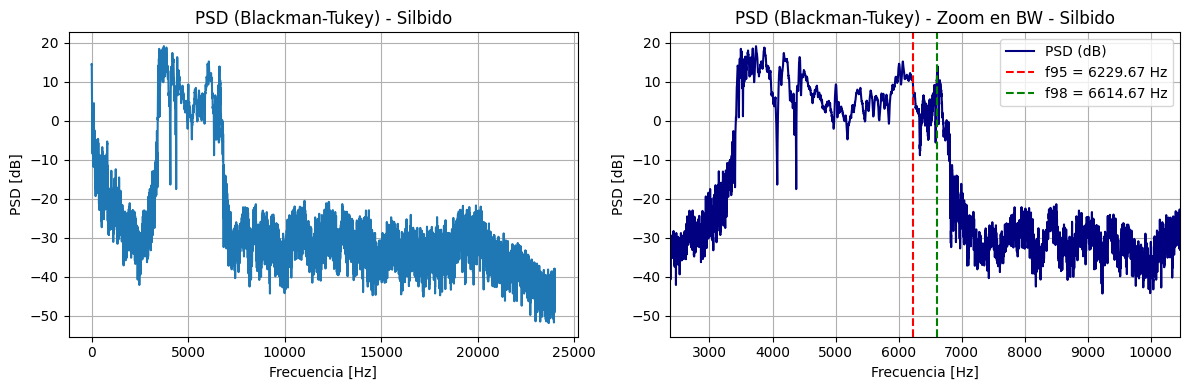

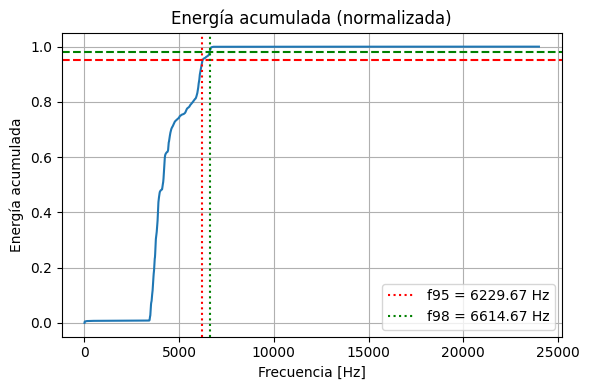

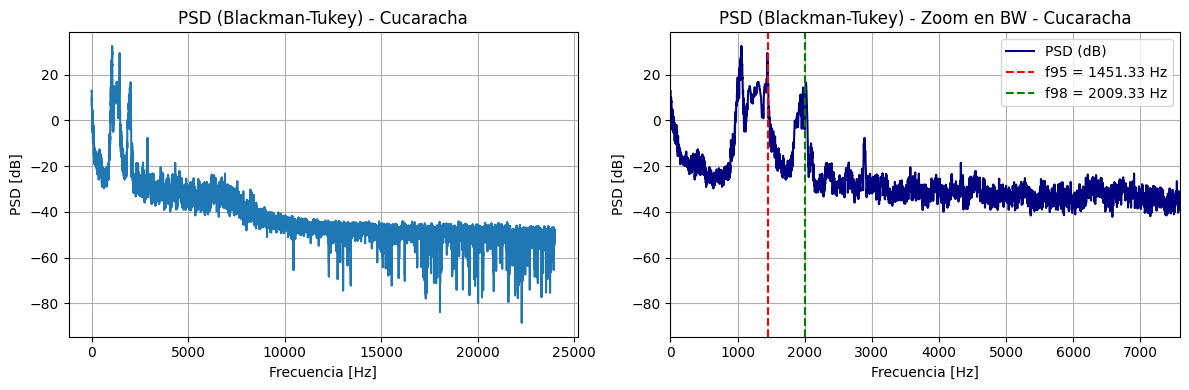

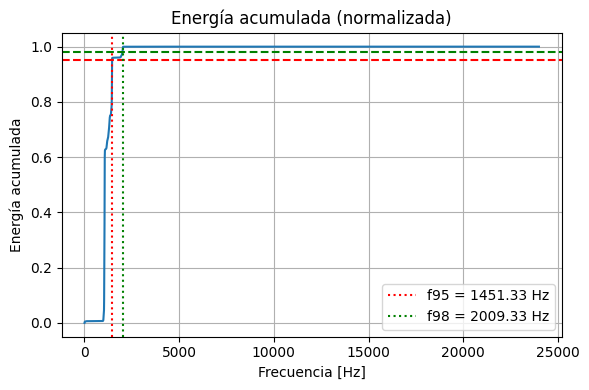

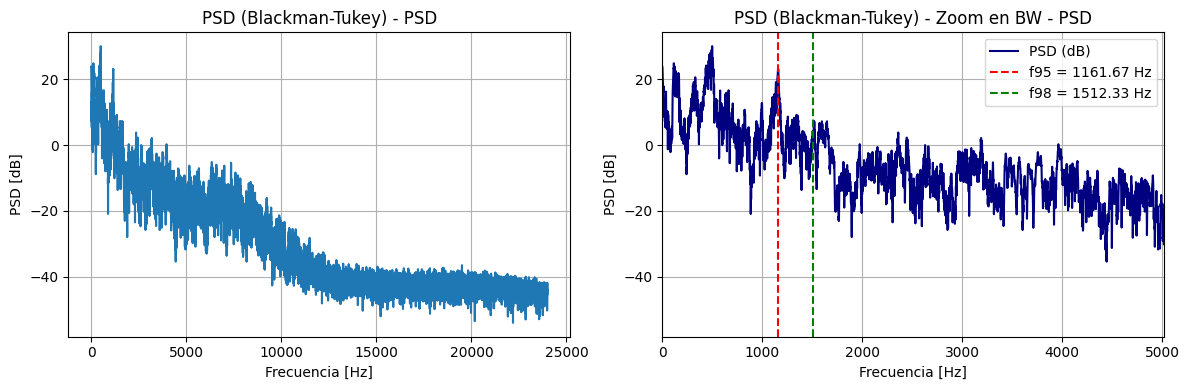

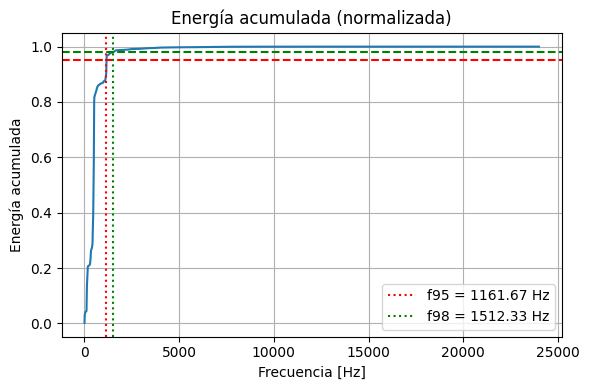

,Señal,Fs [Hz],BW 95% [Hz],BW 98% [Hz]
0,Silbido,48000,6229.67,6614.67
1,Cucaracha,48000,1451.33,2009.33
2,PSD,48000,1161.67,1512.33


In [5]:
#Señal de AUDIO
Audio_Silbido = analizar_signal('silbido.wav',nombre='Silbido')
Audio_Cucaracha = analizar_signal('la cucaracha.wav',nombre='Cucaracha')
Audio_PSD = analizar_signal('prueba psd.wav',nombre='PSD')

resultados_AUDIO = [Audio_Silbido, Audio_Cucaracha, Audio_PSD]
tabla_3 = pd.DataFrame(resultados_AUDIO)
display(tabla_3.round(2))

En este caso, al analizar señales de audio, se observa que el archivo correspondiente al "silbido" presenta un ancho de banda significativamente mayor que el resto. Esto indica una mayor presencia de componentes en altas frecuencias, lo cual es esperable en un silbido, ya que se caracteriza por un tono agudo. Por lo tanto, es lógico que la mayor parte de su energía se concentre en ese rango de frecuencias.

En cambio, los otros dos archivos presentan un ancho de banda mucho menor, correspondiente a frecuencias de notas de voz. Un caso particular es el de audio "cucaracha" que muestra una mayor variación entre la energía concentrada al 95% y al 98%; esto sugiere que tiene más componentes armónicos o variaciones de tono, lo cual tiene sentido porque es una grabación de una canción. Mientras que las restantes presentan un contenido espectral más concentrado (indicando una señal más simple o estable en frecuencia). 

In [6]:
#tabla comparativa de todos los resultados obtenidos: 
# Crear lista con los resultados
todos_los_resultados = [resultados_PPG, resultados_ECG, Audio_Silbido, Audio_Cucaracha, Audio_PSD]
# Armar tabla
tabla_comparativa = pd.DataFrame(todos_los_resultados)
display(tabla_comparativa.round(2))

,Señal,Fs [Hz],BW 95% [Hz],BW 98% [Hz]
0,PPG,400,4.02,5.38
1,ECG,1000,23.67,28.03
2,Silbido,48000,6229.67,6614.67
3,Cucaracha,48000,1451.33,2009.33
4,PSD,48000,1161.67,1512.33


A partir del análisis espectral realizado, se puede concluir que las señales de caracter biomédico (PPG y ECG) presentan un contenido espectral acotado y concentrado en frecuencias bajas, lo cual es coherente con su naturaleza fisiológica lenta y periódica. Este comportamiento se refleja tanto en la forma de la densidad espectral de potencia como en los bajos valores de ancho de banda obtenidos para los umbrales del 95% y 98% de energía (que pueden visualizarse en la tabla compartiva y que fueron previamente analizados)

Mietras que las señales de audio presentaron una distribución espectral mucho más amplia. Por su parte el archivo "silbido" presentó el mayor ancho de banda, con la mayoría de su energía ubicada en altas frecuencias, lo que concuerda con su tono agudo. La grabación de la melodía cucaracha fue la que mayr dispersión mostró l,o que evidencia una señal más rica en componentes armónicos y variaciones tonales.

Este trabajo permitió no solo comparar señales de distinta naturaleza en términos espectrales, sino también evidenciar cómo el uso de criterios energéticos parciales (95%-98%) permite estimar de manera más robusta el ancho de banda efectivo de señales reales, evitando la influencia de ruido o picos aleatorios; y al comparar los resultqados poder evidenciar claramente de que tipo de señal se trata, por ejemplo, para diferenciar entre una señal fisiológica y una de audio.